## Hydra Effect

In [1]:
import os
import torch
import pickle
import plotly.io as pio
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
renderer = "jupyterlab"
pio.renderers.default = renderer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(tensor.numpy(), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=tensor.numpy(), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = x.numpy()
    y = y.numpy()
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

# Function to load a pickle object from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

## Load Results

In [3]:
def flatten_all_results():
    pickle_files = [f for f in os.listdir("hydra") if f.split(".")[-1]=="pickle"]
    pickle_files = [f for f in pickle_files if "results" in f]
    results = []
    for file in pickle_files: 
        results += load_pickle("hydra/" + file)
        
    results_dict = {}
    for d in results: 
        for k,v in d.items(): 
            results_dict.setdefault(k, []).append(v)
            
    return results_dict

        
results = flatten_all_results()

In [4]:
list(results.keys())

['layer_names',
 'clean_mle_residual_logits',
 'clean_target_residual_logits',
 'corrupted_mle_residual_logits',
 'corrupted_target_residual_logits',
 'ablated_mle_residual_logits',
 'ablated_target_residual_logits',
 'total_ablated_mle_logits',
 'total_ablated_target_logits',
 'clean_mle_logit',
 'clean_target_logit',
 'corrupted_mle_logit',
 'corrupted_target_logit']

In [5]:
layer_names = results["layer_names"][0]
clean_mle_residual_logits = torch.stack(results["clean_mle_residual_logits"])
clean_target_residual_logits = torch.stack(results["clean_target_residual_logits"])
corrupted_mle_residual_logits = torch.stack(results["corrupted_mle_residual_logits"])
corrupted_target_residual_logits = torch.stack(results["corrupted_target_residual_logits"])
ablated_mle_residual_logits = torch.stack(results["ablated_mle_residual_logits"])
ablated_target_residual_logits = torch.stack(results["ablated_target_residual_logits"])
total_ablated_mle_logits = torch.stack(results["total_ablated_mle_logits"])
total_ablated_target_logits = torch.stack(results["total_ablated_target_logits"])
clean_mle_logit = torch.stack(results["clean_mle_logit"])
clean_target_logit = torch.stack(results["clean_target_logit"])
corrupted_mle_logit = torch.stack(results["corrupted_mle_logit"])
corrupted_target_logit = torch.stack(results["corrupted_target_logit"])

results = {
    "layer_names": layer_names,
    "clean_mle_residual_logits": clean_mle_residual_logits,
    "clean_target_residual_logits": clean_target_residual_logits,
    "corrupted_mle_residual_logits": corrupted_mle_residual_logits,
    "corrupted_target_residual_logits": corrupted_target_residual_logits,
    "ablated_mle_residual_logits": ablated_mle_residual_logits,
    "ablated_target_residual_logits": ablated_target_residual_logits,
    "total_ablated_mle_logits": total_ablated_mle_logits,
    "total_ablated_target_logits": total_ablated_target_logits,
    "clean_mle_logit": clean_mle_logit,
    "clean_target_logit": clean_target_logit,
    "corrupted_mle_logit": corrupted_mle_logit,
    "corrupted_target_logit": corrupted_target_logit,
}

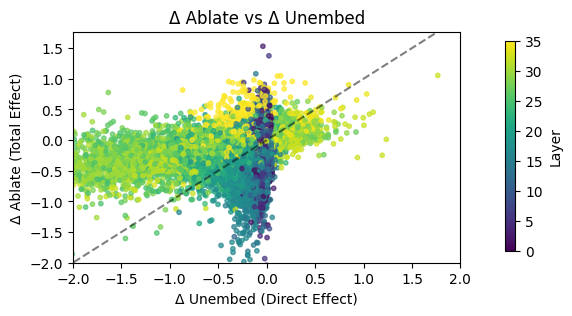

In [11]:
def plot_delta_ablate_vs_delta_unembed(results, title, logit="mle", ablated="all", view_effect="all", use_direct_effect=False):
    if ablated=="all":
        ablated="_"
    if view_effect=="all":
        view_effect="_"
        
    layer_names = results["layer_names"]
    effect_mask = torch.tensor([view_effect in layer_name for layer_name in layer_names])
    effect_mask = effect_mask[2:]
                       
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_residual = results["clean_mle_residual_logits"]
        ablated_final_logits = results["total_ablated_mle_logits"]
        clean_final_logit = results["clean_mle_logit"]

    elif logit=="target":
        ablated_residual_logits = results["ablated_target_residual_logits"]
        clean_residual = results["clean_target_residual_logits"]
        ablated_final_logits = results["total_ablated_target_logits"]
        clean_final_logit = results["clean_target_logit"]
    
    batch, ablation_idx, effect_idx = ablated_residual_logits.shape
    clean_residual = clean_residual[:,2:]
    ablated_residual_logits = ablated_residual_logits[:, :, 2:]
    
    delta_unembed = torch.zeros((batch, clean_residual.shape[-1]))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
        
    if use_direct_effect: 
        delta_unembed = delta_unembed - clean_residual
    
    delta_ablate = ablated_final_logits - clean_final_logit
    
    delta_ablate = delta_ablate[:, effect_mask]
    delta_unembed = delta_unembed[:, effect_mask]

    #plotting
    fig = plt.figure(figsize=(5, 3))
    for i in range(batch): 
        x = delta_unembed[i]
        y = delta_ablate[i]
        layer_colors = plt.cm.viridis(np.linspace(0, 1, x.shape[-1]))
        plt.scatter(x = x, y = y, c=layer_colors, s=10, marker='o', alpha=0.7)
        
    min_val = min(delta_unembed.min(), delta_ablate.min())
    max_val = max(delta_unembed.max(), delta_ablate.max())
    
    plt.ylabel("Δ Ablate (Total Effect)")
    plt.xlabel("Δ Unembed (Direct Effect)")
    
    magnitude_axis=2
    plt.xlim(-magnitude_axis, magnitude_axis)
    plt.ylim(-magnitude_axis, max_val)

    # Set the limits for the dashed line to go through zero and extend on both sides
    line_min = min(min_val, 0)
    line_max = max(max_val, 0)
    plt.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='dashed', alpha=0.5)
    plt.title(title)
    cax = fig.add_axes([0.99, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), cax=cax)
    tick_locations = np.linspace(0, 1, 8)  # Adjust the number of ticks as needed
    tick_labels = np.arange(0, 36, 5)
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Layer')
    plt.show()

    
plot_delta_ablate_vs_delta_unembed(results, title="Δ Ablate vs Δ Unembed", 
                                   logit="mle", ablated="attn", view_effect="attn", use_direct_effect=True)

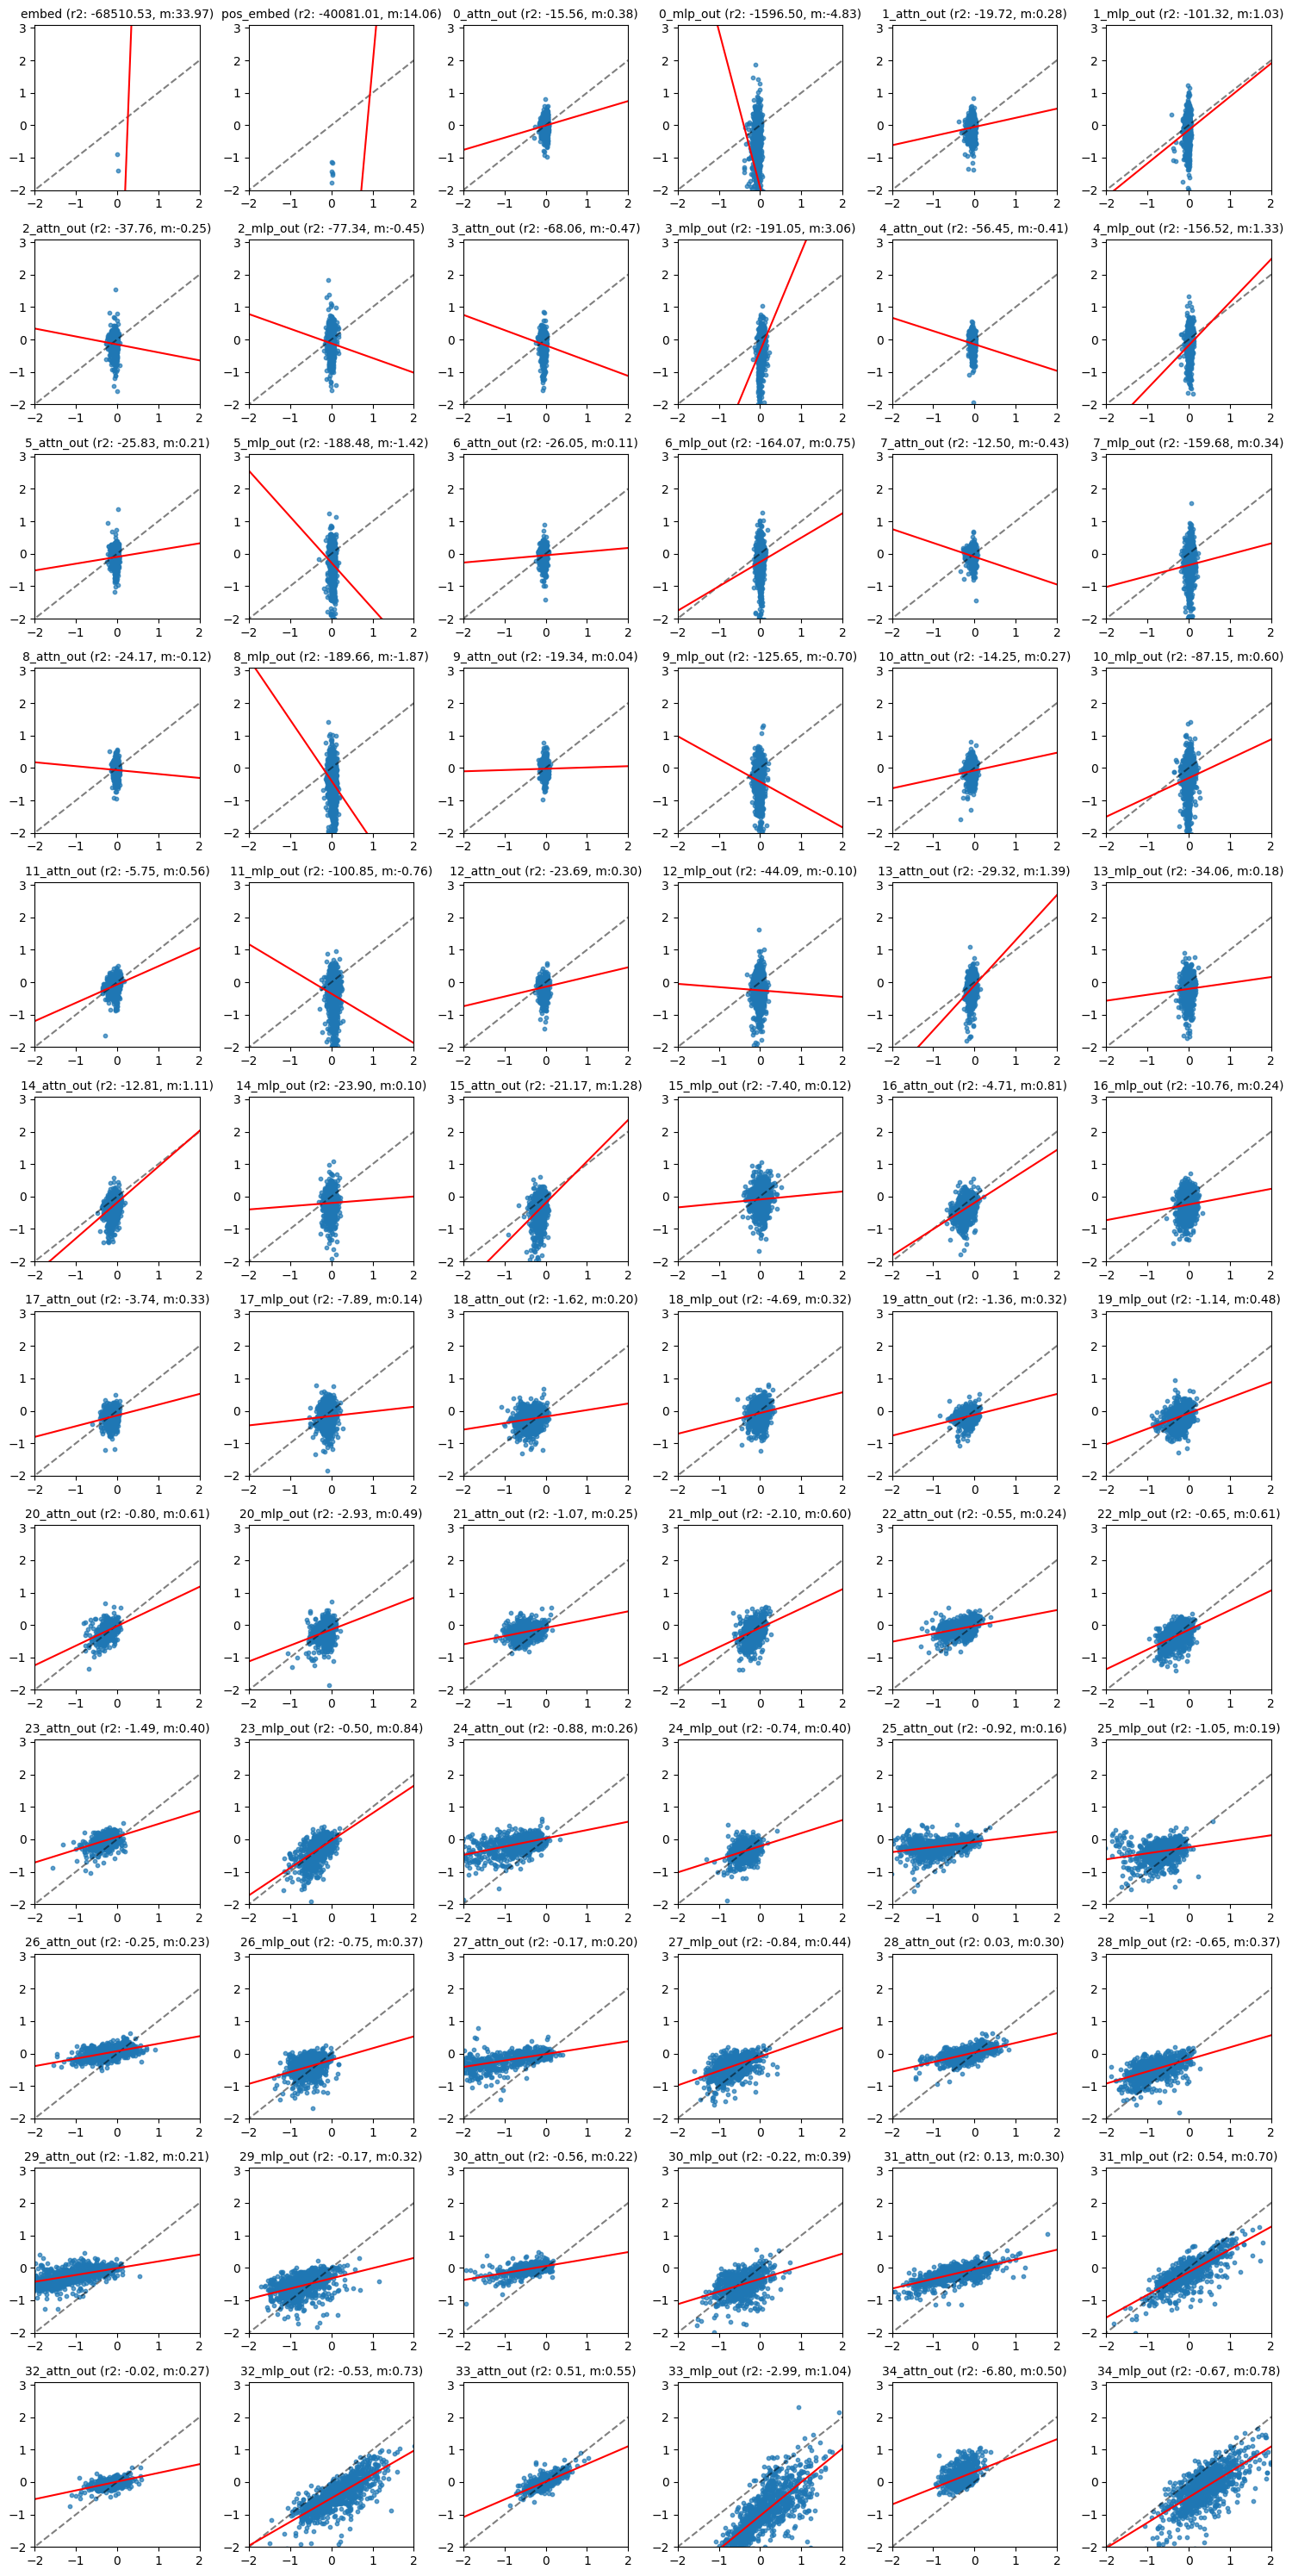

In [10]:

def plot_delta_ablate_vs_delta_unembed_by_layer(results, title, logit="mle", ablated="all", view_effect="all", use_direct_effect=False):
    if ablated=="all":
        ablated="_"
    if view_effect=="all":
        view_effect="_"
        
    layer_names = results["layer_names"]
    effect_mask = torch.tensor([view_effect in layer_name for layer_name in layer_names])
    effect_mask = effect_mask[2:]
                       
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_residual = results["clean_mle_residual_logits"]
        ablated_final_logits = results["total_ablated_mle_logits"]
        clean_final_logit = results["clean_mle_logit"]

    elif logit=="target":
        ablated_residual_logits = results["ablated_target_residual_logits"]
        clean_residual = results["clean_target_residual_logits"]
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_final_logit = results["clean_target_logit"]
    
    batch, ablation_idx, effect_idx = ablated_residual_logits.shape
    clean_residual = clean_residual[:,2:]
    ablated_residual_logits = ablated_residual_logits[:, :, 2:]
    ablated_residual_logits = ablated_residual_logits[:,:, effect_mask]
    
    delta_unembed = torch.zeros((batch, effect_mask.sum()))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
        
    if use_direct_effect: 
        delta_unembed = delta_unembed - clean_residual
    delta_unembed_mean = delta_unembed.mean(dim=0)

    ablated_final_logits = ablated_final_logits[:, effect_mask]
    delta_ablate = ablated_final_logits - clean_final_logit

    num_cols = 6
    num_rows = 6 if delta_ablate.shape[-1] == 36 else 12

    # Create a figure and an array of subplots with the specified grid layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))  # Adjust the figsize as needed

    # Iterate through each subplot and do something (for demonstration, we'll set a title)
    k = 0
    for i in range(num_rows):
        for j in range(num_cols):
            de = delta_unembed[:, k]
            da = delta_ablate[:, k]
        
            ax = axes[i, j]
            # ax.axis('off')  # Turn off axis for cleaner appearance
            
            ax.scatter(x = de, y = da, s=10, marker='o', alpha=0.7)
            
            min_val = min(delta_unembed.min(), delta_ablate.min())
            max_val = max(delta_unembed.max(), delta_ablate.max())
            magnitude_axis=2
            ax.set_xlim(-magnitude_axis, magnitude_axis)
            ax.set_ylim(-magnitude_axis, max_val)

            # Set the limits for the dashed line to go through zero and extend on both sides
            line_min = min(min_val, 0)
            line_max = max(max_val, 0)
            ax.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='dashed', alpha=0.5)
            
            x = de
            y = da
            r2 = r2_score(x, y, force_finite=True)
            model = LinearRegression()
            x_reshaped = x.reshape(-1, 1)
            model.fit(x_reshaped, y)
            slope = model.coef_[0]
            
            x = np.linspace(line_min, line_max, 10).reshape(-1, 1)
            y_pred = model.predict(x)
            ax.plot(x, y_pred, color='red')
            
            ax.set_title(f"{layer_names[k]} (r2: {r2:.2f}, m:{slope:.2f})", fontsize=10)
            k+=1

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()
    
plot_delta_ablate_vs_delta_unembed_by_layer(results, title="Δ Ablate vs Δ Unembed", 
                                   logit="mle", ablated="all", view_effect="all", use_direct_effect=True)

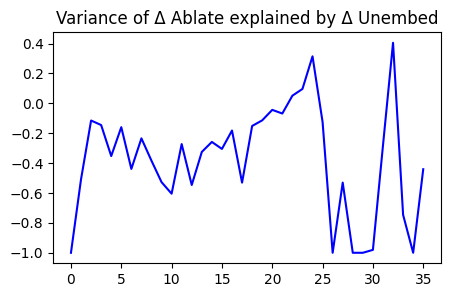

In [13]:
def plot_variance_delta_ablate_vs_delta_unembed(results, title, logit="mle", ablated="all", view_effect="all", use_direct_effect=False):
    if ablated=="all":
        ablated="_"
    if view_effect=="all":
        view_effect="_"
        
    layer_names = results["layer_names"]
    effect_mask = torch.tensor([view_effect in layer_name for layer_name in layer_names])
    effect_mask = effect_mask[2:]
                       
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_residual = results["clean_mle_residual_logits"]
        ablated_final_logits = results["total_ablated_mle_logits"]
        clean_final_logit = results["clean_mle_logit"]

    elif logit=="target":
        ablated_residual_logits = results["ablated_target_residual_logits"]
        clean_residual = results["clean_target_residual_logits"]
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_final_logit = results["clean_target_logit"]
    
    batch, ablation_idx, effect_idx = ablated_residual_logits.shape
    clean_residual = clean_residual[:,2:]
    ablated_residual_logits = ablated_residual_logits[:, :, 2:]
    
    delta_unembed = torch.zeros((batch, ablated_residual_logits.shape[-1]))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
        
    if use_direct_effect: 
        delta_unembed = delta_unembed - clean_residual
    delta_unembed_mean = delta_unembed.mean(dim=0)

    delta_ablate = ablated_final_logits - clean_final_logit
    
    delta_ablate = delta_ablate[:, effect_mask]
    delta_unembed = delta_unembed[:, effect_mask]

    r2_scores = []
    for layer in range(delta_unembed.shape[-1]):
        r2 = r2_score(delta_ablate[:, layer], delta_unembed[:, layer])
        r2_scores.append(r2)

    # Clamp the lower end of R2 scores to -1
    r2_scores = np.maximum(r2_scores, -1.0)

    # r2_scores = torch.clamp(r2_scores, 1, -1)
    
    fig = plt.figure(figsize=(5, 3))
    plt.plot(r2_scores, color='blue')
    plt.title(title)
    plt.show()
    
plot_variance_delta_ablate_vs_delta_unembed(results, title="Variance of Δ Ablate explained by Δ Unembed", 
                                   logit="mle", ablated="mlp", view_effect="mlp", use_direct_effect=True)

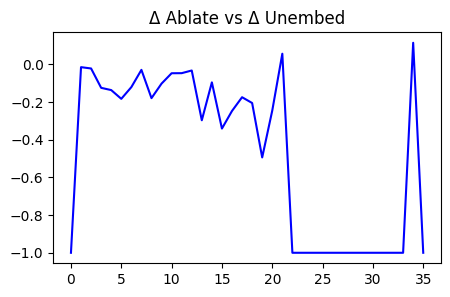

In [14]:
plot_variance_delta_ablate_vs_delta_unembed(results, title="Δ Ablate vs Δ Unembed", 
                                   logit="mle", ablated="attn", view_effect="attn", use_direct_effect=True)

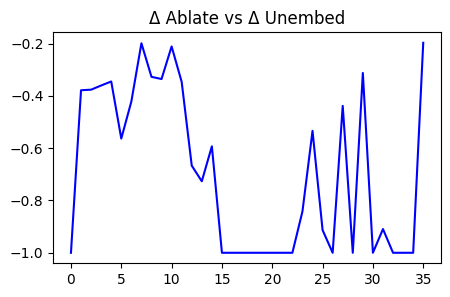

In [15]:
plot_variance_delta_ablate_vs_delta_unembed(results, title="Δ Ablate vs Δ Unembed", 
                                   logit="mle", ablated="attn", view_effect="attn", use_direct_effect=False)

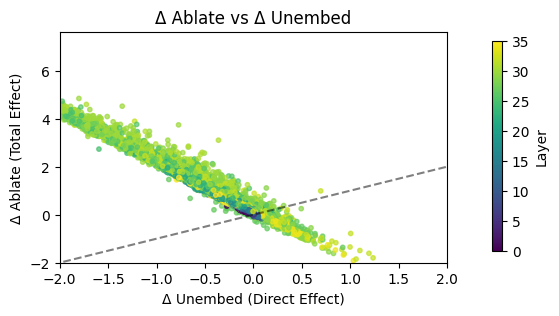

In [18]:
def plot_compensatory_effect(results, title, logit="mle", ablated="all", 
                             view_effect="all", plot_type="line"):    
    if ablated=="all":
        ablated="_"
    if view_effect=="all":
        view_effect="_"
        
    layer_names = results["layer_names"]
    effect_mask = torch.tensor([view_effect in layer_name for layer_name in layer_names])
    effect_mask = effect_mask[2:]
    
    ablate_mask = torch.tensor([ablated in layer_name for layer_name in layer_names])
    ablate_mask = ablate_mask[2:]
    
    
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_residual = results["clean_mle_residual_logits"]
        ablated_final_logits = results["total_ablated_mle_logits"]
        clean_final_logit = results["clean_mle_logit"]

    elif logit=="target":
        ablated_residual_logits = results["ablated_target_residual_logits"]
        clean_residual = results["clean_target_residual_logits"]
        ablated_final_logits = results["total_ablated_target_logits"]
        clean_final_logit = results["clean_target_logit"]
    
    batch, ablation_idx, effect_idx = ablated_residual_logits.shape
    clean_residual = clean_residual[:,2:]
    ablated_residual_logits = ablated_residual_logits[:, :, 2:]
    
    
    delta_unembed = torch.zeros((batch, clean_residual.shape[-1]))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
    direct_effect = (delta_unembed - clean_residual).unsqueeze(-1)   
    
    direct_effect_ablated = direct_effect[:, ablate_mask].squeeze()
    direct_effect_compensated = direct_effect[:, effect_mask].squeeze()

    ablated_residual_logits = ablated_residual_logits[:, ablate_mask, :]
    ablated_residual_logits = ablated_residual_logits[:,:, effect_mask]
    
    compensatory_effect = torch.zeros((batch, ablate_mask.sum()-1))
    
    
    for i in range(batch):
        delta_direct_effect = ablated_residual_logits[i] - direct_effect_compensated[i]
        for j in range(compensatory_effect.shape[-1]):
            compensatory_effect[i, j] = delta_direct_effect[j,j+1].sum(dim=-1) 
                     
    compensatory_effect_mean = compensatory_effect.mean(dim=0)    
    
    compensatory_effect = compensatory_effect.squeeze()
    direct_effect = direct_effect.squeeze()
    
    direct_effect = direct_effect_ablated[:,1:]
    
    fig = plt.figure(figsize=(5, 3))
    for i in range(batch): 
        x = direct_effect[i]
        y = compensatory_effect[i]
        layer_colors = plt.cm.viridis(np.linspace(0, 1, x.shape[-1]))
        plt.scatter(x = x, y = y, c=layer_colors, s=10, marker='o', alpha=0.7)
        
    min_val = min(direct_effect.min(), compensatory_effect.min())
    max_val = max(direct_effect.max(), compensatory_effect.max())
    
    plt.ylabel("Δ Ablate (Total Effect)")
    plt.xlabel("Δ Unembed (Direct Effect)")
    
    magnitude_axis=2
    plt.xlim(-magnitude_axis, magnitude_axis)
    plt.ylim(-magnitude_axis, max_val)

    # Set the limits for the dashed line to go through zero and extend on both sides
    line_min = min(min_val, 0)
    line_max = max(max_val, 0)
    plt.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='dashed', alpha=0.5)
    plt.title(title)
    cax = fig.add_axes([0.99, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), cax=cax)
    tick_locations = np.linspace(0, 1, 8)  # Adjust the number of ticks as needed
    tick_labels = np.arange(0, 36, 5)
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Layer')
    plt.show()  
    

plot_compensatory_effect(results, title="Δ Ablate vs Δ Unembed", 
            logit="mle", ablated="attn", view_effect="attn",
            plot_type = "scatter")

In [323]:
plot_compensatory_effect(results, title="Δ Ablate vs Δ Unembed", 
            logit="mle", ablated="all", view_effect="all",
            plot_type = "line")

In [281]:
list(results.keys())

['layer_names',
 'clean_mle_residual_logits',
 'clean_target_residual_logits',
 'corrupted_mle_residual_logits',
 'corrupted_target_residual_logits',
 'ablated_mle_residual_logits',
 'ablated_target_residual_logits',
 'total_ablated_mle_logits',
 'total_ablated_target_logits',
 'clean_mle_logit',
 'clean_target_logit',
 'corrupted_mle_logit',
 'corrupted_target_logit',
 'total_ablated_mle_position_logits',
 'total_ablated_target_position_logits',
 'total_ablated_mle_residual_position_logits',
 'total_ablated_target_residual_position_logits',
 'subject_mask',
 'prompts']

In [283]:
r = results["total_ablated_mle_position_logits"]
s = results["subject_mask"]

for i in range(len(r)):
    print(r[i].shape, s[i].shape)
    



torch.Size([72, 11]) torch.Size([1, 11])
torch.Size([72, 9]) torch.Size([1, 9])
torch.Size([72, 17]) torch.Size([1, 17])
torch.Size([72, 6]) torch.Size([1, 6])
torch.Size([72, 11]) torch.Size([1, 11])
torch.Size([72, 9]) torch.Size([1, 9])
torch.Size([72, 7]) torch.Size([1, 7])
torch.Size([72, 9]) torch.Size([1, 9])
torch.Size([72, 7]) torch.Size([1, 7])
torch.Size([72, 10]) torch.Size([1, 10])
torch.Size([72, 10]) torch.Size([1, 10])
torch.Size([72, 13]) torch.Size([1, 13])
torch.Size([72, 10]) torch.Size([1, 10])
torch.Size([72, 10]) torch.Size([1, 10])
torch.Size([72, 12]) torch.Size([1, 12])
torch.Size([72, 10]) torch.Size([1, 10])
torch.Size([72, 9]) torch.Size([1, 8])
torch.Size([72, 11]) torch.Size([1, 11])
torch.Size([72, 8]) torch.Size([1, 8])
torch.Size([72, 10]) torch.Size([1, 10])
torch.Size([72, 9]) torch.Size([1, 9])
torch.Size([72, 11]) torch.Size([1, 11])
torch.Size([72, 7]) torch.Size([1, 7])
torch.Size([72, 10]) torch.Size([1, 10])
torch.Size([72, 11]) torch.Size([1, 